# Second approach

In [288]:
import control as ctrl
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import sympy as sp

In [289]:
plt.style.use(plt.style.available[9])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Define Transfer Function

In [290]:
numerator = [-1, 1.9, 0.95]
denominator = [1, -0.18, 0.08, -0.08]
H_s = ctrl.tf(numerator,denominator)
H_s

TransferFunction(array([-1.  ,  1.9 ,  0.95]), array([ 1.  , -0.18,  0.08, -0.08]))

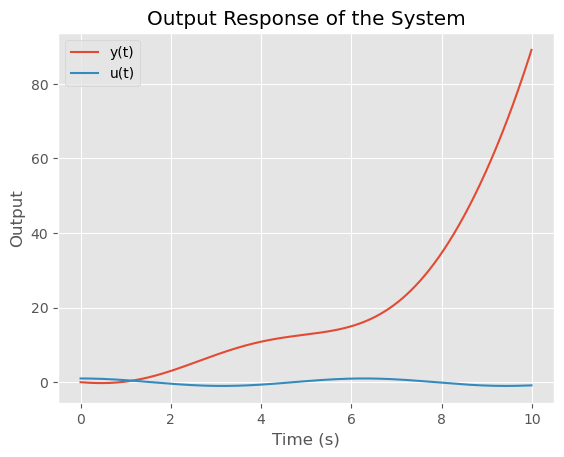

In [291]:
dt =0.01
time = np.arange(0, 10, dt)
f = 1
u_data = np.cos(f*time)#+np.cos(2*time)+np.cos(3*time)

# Step 3: Simulate the output using forced_response
results = ctrl.forced_response(H_s, T=time, U=u_data)

# Plotting the results
plt.figure()
plt.plot(results.time, results.outputs,label='y(t)')
plt.plot(time,u_data,label='u(t)')
plt.title('Output Response of the System')
plt.xlabel('Time (s)')
plt.ylabel('Output')
plt.legend()

plt.show()

## Neural Network

In [292]:
class DeepNetwork(torch.nn.Module):
    def __init__(self, input_dim=8, hidden_dims=[128, 128, 128], num_classes=5):
        super(DeepNetwork, self).__init__()
        layers = []
        dims = [input_dim] + hidden_dims
        
        # Build the hidden layers
        for i in range(len(dims) - 1):
            layers.append(torch.nn.Linear(dims[i], dims[i + 1]))
            layers.append(torch.nn.ReLU())
        
        # Output layer
        layers.append(torch.nn.Linear(dims[-1], num_classes))
        
        # Sequentially stack the layers
        self.model = torch.nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

## Generating White Noise Data

In [293]:
def generate_delayed_data(data, delays):
    delayed_data = []
    for delay in delays:
        padded_data = torch.cat([torch.zeros(delay), data[:-delay]])
        delayed_data.append(padded_data)
    return torch.stack(delayed_data, dim=1)

In [294]:
# Example white noise input signal
torch.manual_seed(42)
input_signal = torch.randn(50)
time = np.arange(0, 10, 0.2)
input_delays = [1, 2]
output_delays = [1, 2]

# Generate delayed input data
input_data_d = generate_delayed_data(input_signal, input_delays)
input_data = torch.cat([input_signal.reshape(-1, 1), input_data_d], dim=1).to(device)

# Generate system response using control library
T, y_ = ctrl.forced_response(H_s, T=time, U=input_signal.numpy())

# Convert output response to PyTorch tensor and generate delayed outputs
output_signal = torch.from_numpy(y_)  # Convert to PyTorch tensor
output_data = generate_delayed_data(output_signal, output_delays).to(device)

In [295]:
model = DeepNetwork(input_dim=input_data.shape[1] + output_data.shape[1], hidden_dims=[64], num_classes=1).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Prepare the data
X = torch.cat([input_data, output_data], dim=1).to(device).float()
y = torch.from_numpy(y_).to(device).float().reshape(-1,1)

# Training loop
num_epochs = 10000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()

    if epoch %5000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 62.48456573486328
Epoch 5000, Loss: 0.00017226494674105197


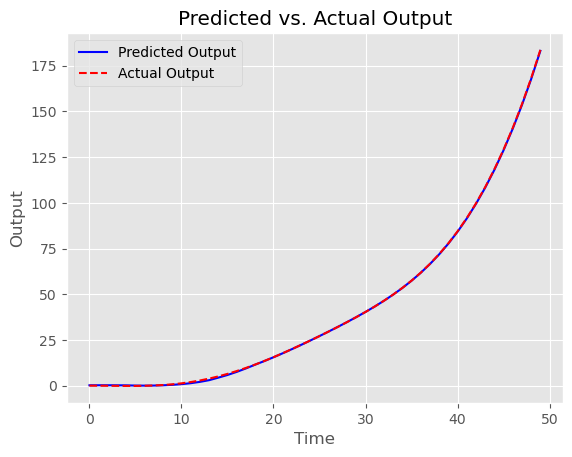

In [296]:
# Test the model with a new input signal (e.g., a sine wave)
test_input = torch.sin(torch.linspace(0, 10, 50))
test_input_data = generate_delayed_data(test_input, input_delays)
test_input_data = torch.cat([test_input.reshape(-1, 1), test_input_data], dim=1).to(device)

T, y_ = ctrl.forced_response(H_s, T=time, U=test_input.numpy())
test_output_data = generate_delayed_data(torch.from_numpy(y_), output_delays).to(device)
X_test = torch.cat([test_input_data, test_output_data], dim=1).to(device).float()

# Combine delayed test input and output for prediction
X_test = torch.cat([test_input_data, test_output_data], dim=1).to(device).float()
predicted_output = model(X_test)

# Plot predicted output and actual output
plt.plot(predicted_output.detach().cpu().numpy(), label="Predicted Output", color="blue")
T, y_ = ctrl.forced_response(H_s, T=time, U=test_input.numpy())
plt.plot(y_, label="Actual Output", color="red", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Output")
plt.legend()
plt.title("Predicted vs. Actual Output")
plt.show()

# Part II

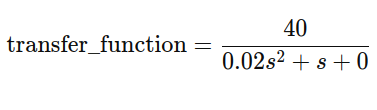
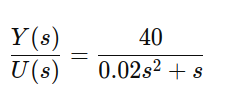
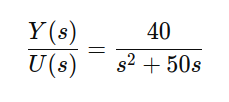

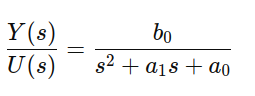
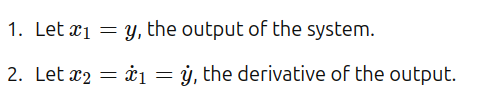
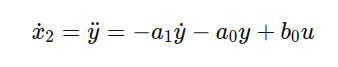


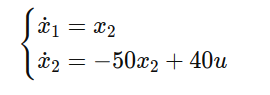
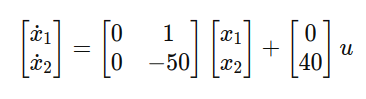

State parameters are the result of x1 and x2 when the sine wave is the input to the system. These states are obtained by solving the differential equation above.

## Neural Network

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DeepNetwork(torch.nn.Module):
    def __init__(self, input_dim=8, hidden_dims=[128, 128, 128], num_classes=5):
        super(DeepNetwork, self).__init__()
        layers = []
        dims = [input_dim] + hidden_dims
        
        # Build the hidden layers
        for i in range(len(dims) - 1):
            layers.append(torch.nn.Linear(dims[i], dims[i + 1]))
            layers.append(torch.nn.ReLU())
        
        # Output layer
        layers.append(torch.nn.Linear(dims[-1], num_classes))
        
        # Sequentially stack the layers
        self.model = torch.nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

## Filter

In [298]:
def GetTheFilter_StateSpaceMats(A:sp.MutableDenseMatrix):
    s = sp.symbols('s')

    I = sp.eye(A.cols)
    
    M_s = (s*I-A).inv()
    sp.pprint(M_s)


    nums=[]
    dens=[]

    for entry in M_s:
        num_expr = sp.numer(entry)
        den_expr = sp.denom(entry)
        num_poly = sp.Poly(num_expr, s)
        den_poly = sp.Poly(den_expr, s)
        num_coeffs = [float(coef) for coef in num_poly.coeffs()]
        den_coeffs = [float(coef) for coef in den_poly.coeffs()]
        nums.append(num_coeffs)
        dens.append(den_coeffs)

    def GetNumDenReady(size,input):
        output = [[] for i in range(size)]

        for index, item in enumerate(input):
            group_index = index % size
            output[group_index].append(item)
        return output
    
    nums = GetNumDenReady(M_s.cols,nums)
    dens = GetNumDenReady(M_s.cols,dens)
    M_system = ctrl.tf(nums, dens)
    ss_sys = ctrl.tf2ss(M_system) 
    A = ss_sys.A
    B = ss_sys.B
    C = ss_sys.C
    D = ss_sys.D
    return M_system
A_filter = 1*sp.eye(1)
Filter = GetTheFilter_StateSpaceMats(A_filter)
Filter


⎡  1  ⎤
⎢─────⎥
⎣s - 1⎦


TransferFunction(array([1.]), array([ 1., -1.]))

## System

In [299]:
numerator = [40]
denominator = [0.02,1,0]
H_s = ctrl.tf(numerator,denominator)
H_s

TransferFunction(array([40]), array([0.02, 1.  , 0.  ]))

### input signal

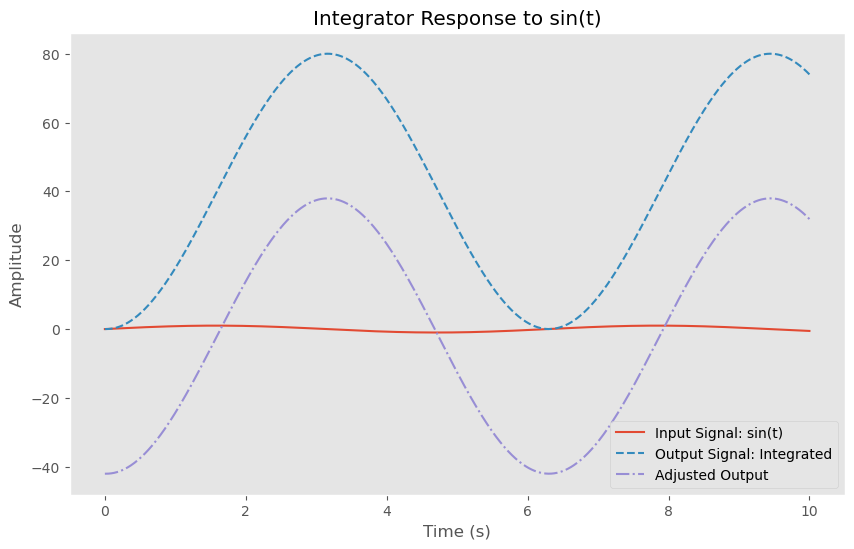

In [300]:
# Define time and input signal
num_pints = 1000
T_end = 10
t = np.linspace(0, T_end, num_pints)  # Time vector
input_signal = np.sin(t)  # Input signal

# Simulate the response
t_out, y_out_ = ctrl.forced_response(H_s, T=t, U=input_signal)

# Remove the DC offset (mean value)
y_out = y_out_ - np.mean(y_out_)
y_out_normalized = (y_out - np.min(y_out)) / (np.max(y_out) - np.min(y_out))

# Plot the input and output signals
plt.figure(figsize=(10, 6))
plt.plot(t, input_signal, label="Input Signal: sin(t)")
plt.plot(t_out, y_out_, label="Output Signal: Integrated", linestyle='--')
plt.plot(t_out, y_out, label="Adjusted Output", linestyle='-.')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Integrator Response to sin(t)")
plt.legend()
plt.grid()
plt.show()

y_out = y_out_normalized

### Train signal

In [301]:
torch.manual_seed(42)
input_signal_ = torch.randn(num_pints)
time = np.arange(0, T_end, T_end/num_pints)

T_, y_ = ctrl.forced_response(H_s, T=time, U=input_signal_)

output_signal = torch.from_numpy(y_).to(device)

x_hat = torch.rand_like(input_signal_)

# Prepare the data
X = torch.cat([input_signal_.reshape(-1, 1), x_hat.reshape(-1, 1)], dim=1).to(device).float()
y = torch.from_numpy(y_).to(device).float().reshape(-1,1)


print(f'input_signal_ shape: {input_signal_.shape}')
print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')


input_signal_ shape: torch.Size([1000])
X shape: torch.Size([1000, 2])
y shape: torch.Size([1000, 1])


In [302]:
input_signal_torch = torch.from_numpy(input_signal).reshape(-1,1).to(device)
X = torch.cat([input_signal_torch, input_signal_torch], dim=1).to(device).float()
y = torch.from_numpy(y_out).to(device).float().reshape(-1,1)

model = DeepNetwork(input_dim=X.shape[1], hidden_dims=[1024, 1024], num_classes=1).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Training loop
num_epochs = 10000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X)    
    x_hat = outputs.detach() 
    T_, x_hat = ctrl.forced_response(Filter, T=time, U=x_hat.reshape(-1,).cpu().numpy())
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()
    
    X = torch.cat([input_signal_.reshape(-1, 1).to(device), torch.from_numpy(x_hat).reshape(-1,1).to(device)], dim=1).float()
    
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 0.13058240711688995
Epoch 1000, Loss: 0.07580161094665527
Epoch 2000, Loss: 0.02166358195245266
Epoch 3000, Loss: 0.0361478328704834
Epoch 4000, Loss: 0.07508713006973267
Epoch 5000, Loss: 0.002347992965951562
Epoch 6000, Loss: 0.004949311260133982
Epoch 7000, Loss: 0.02805226296186447
Epoch 8000, Loss: 0.0650300532579422
Epoch 9000, Loss: 0.01780749298632145


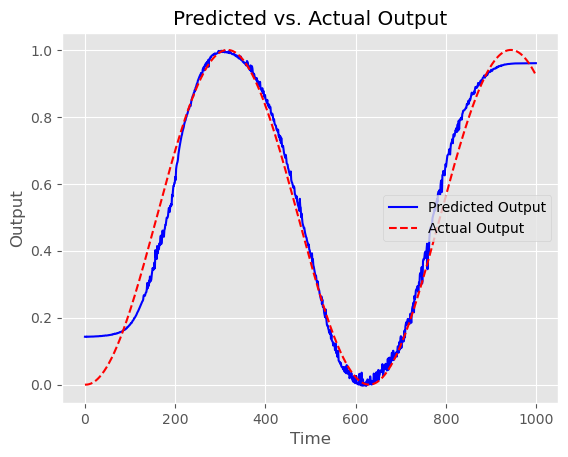

In [303]:
input_signal_torch = torch.from_numpy(input_signal).reshape(-1,1)
X_test = X

# Combine delayed test input and output for prediction
predicted_output = model(X_test)

# Plot predicted output and actual output
plt.plot(predicted_output.detach().cpu().numpy(), label="Predicted Output", color="blue")
plt.plot(y_out, label="Actual Output", color="red", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Output")
plt.legend()
plt.title("Predicted vs. Actual Output")
plt.show()

# Practice 1

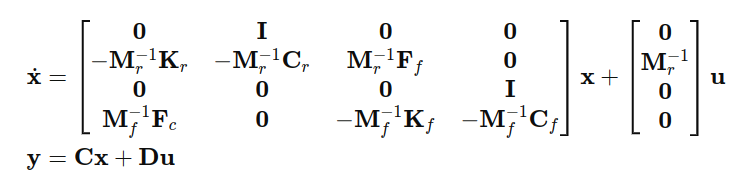
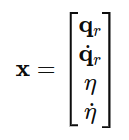
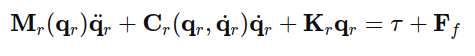

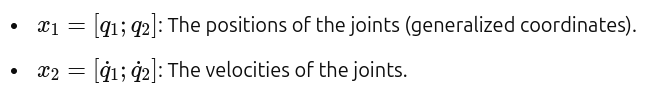
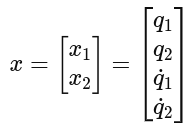

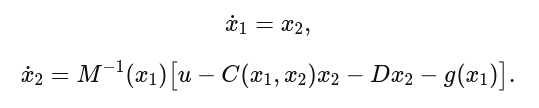
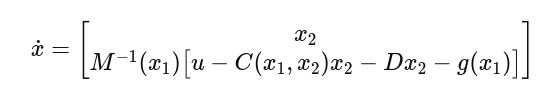

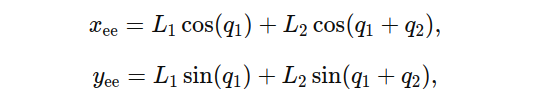
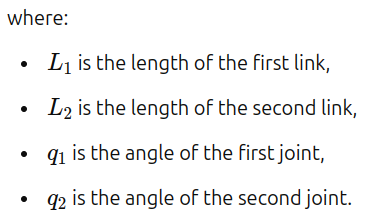

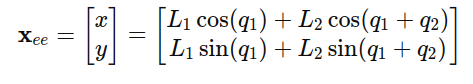
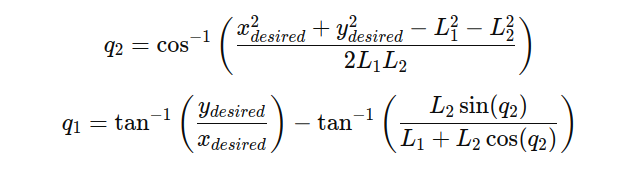

In [304]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Define system parameters
a1, a2, a3, a4 = 200.01, 23.5, 122.5, 25
b1, b2 = 784.8, 245.25

# Dynamics functions
def inertia_matrix(q2):
    """Compute the inertia matrix M."""
    M = np.array([
        [a1 + 2 * a4 * np.cos(q2), a2 + a4 * np.cos(q2)],
        [a2 + a4 * np.cos(q2), a3]
    ])
    return M

def coriolis_matrix(q1_dot, q2_dot, q2):
    """Compute the Coriolis matrix C."""
    C = a4 * np.sin(q2) * np.array([
        [-q2_dot, -(q1_dot + q2_dot)],
        [q1_dot, 0]
    ])
    return C

def gravity_vector(q1, q2):
    """Compute the gravity vector g."""
    g = np.array([
        b1 * np.cos(q1) + b2 * np.cos(q1 + q2),
        b2 * np.cos(q1 + q2)
    ])
    return g

# Define the nonlinear dynamics
def state_dynamics(t, x, u):
    q1, q2, q1_dot, q2_dot = x  # States
    u1, u2 = u  # Inputs
    
    # Define matrices
    M = inertia_matrix(q2)
    C = coriolis_matrix(q1_dot, q2_dot, q2)
    g = gravity_vector(q1, q2)
    D = np.zeros(2)
    
    # Compute the accelerations
    M_inv = np.linalg.inv(M)
    x2_dot = M_inv @ (u - C @ [q1_dot, q2_dot] - D @ [q1_dot, q2_dot] - g)
    
    # Return the state derivatives
    return [q1_dot, q2_dot, x2_dot[0], x2_dot[1]] 

(4, 100)


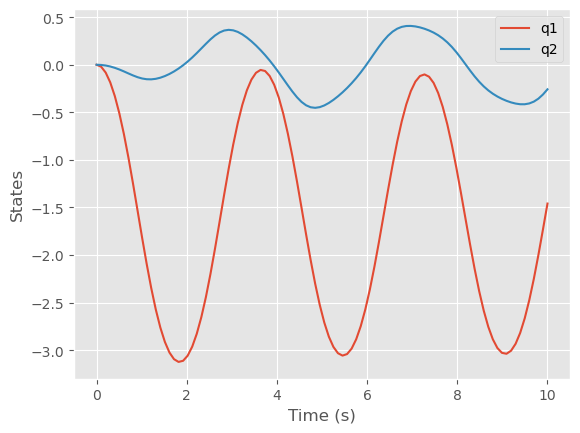

In [305]:
# Simulation settings
t_span = (0, 10)  # Time range (0 to 10 seconds)
x0 = [0, 0, 0, 0]  # Initial states
u = [0, 0]  # Constant input

# Solve the system using solve_ivp
sol = solve_ivp(state_dynamics, t_span, x0, args=(u,), t_eval=np.linspace(0, 10, 100))

print(sol.y.shape)

# Plot the results
plt.plot(sol.t, sol.y[0], label="q1")
plt.plot(sol.t, sol.y[1], label="q2")
plt.xlabel("Time (s)")
plt.ylabel("States")
plt.legend()
plt.show()


## Identifier

In [306]:
# Example white noise input signal
torch.manual_seed(42)
num_data = 50
end_time = 10
num_time = 100
num_states = 4

input_signal = np.random.rand(num_data,2)
time = np.arange(0, end_time, end_time/num_time)

X = torch.from_numpy(input_signal).to(device).float()
y = torch.zeros((num_data, num_states*num_time)).to(device)

for i in range(num_data):
    sol = solve_ivp(state_dynamics, (0, 10), x0, args=(input_signal[i],), t_eval=np.linspace(0, end_time, num_time))
    x_hat = sol.y.reshape(-1, 1)
    x_hat_torch = torch.from_numpy(x_hat).to(device).float()
    y[i] = x_hat_torch.t()

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")


X shape: torch.Size([50, 2])
y shape: torch.Size([50, 400])


In [307]:
model = DeepNetwork(input_dim=X.shape[1], hidden_dims=[64], num_classes=num_states*num_time).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()

    if epoch %5000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 2.0264406204223633
Epoch 5000, Loss: 1.0626463335938752e-06


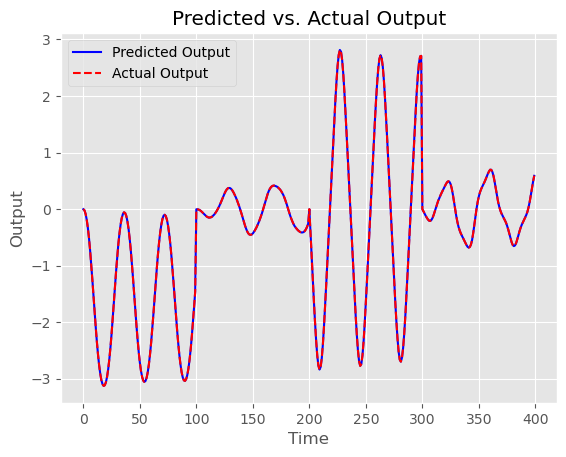

In [308]:
X_test = torch.rand(2).to(device)

# Combine delayed test input and output for prediction
predicted_output = model(X_test)
sol = solve_ivp(state_dynamics, (0, 10), x0, args=(X_test.cpu().numpy(),), t_eval=np.linspace(0, end_time, num_time))
y_out = sol.y.reshape(-1, 1)
# y_out = 

# Plot predicted output and actual output
plt.plot(predicted_output.detach().cpu().numpy(), label="Predicted Output", color="blue")
plt.plot(y_out, label="Actual Output", color="red", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Output")
plt.legend()
plt.title("Predicted vs. Actual Output")
plt.show()

# Practice 2

## Define Transfer Function

In [309]:
numerator = [1, -0.8, 0]
denominator = [1, -(0.1 + 0.5 + 0.94), (0.1*0.5 + 0.1*0.94 + 0.5*0.94), -(0.1*0.5*0.94)]
G = ctrl.TransferFunction(numerator, denominator, True)  # True indicates discrete-time
G


TransferFunction(array([ 1. , -0.8,  0. ]), array([ 1.   , -1.54 ,  0.614, -0.047]), True)

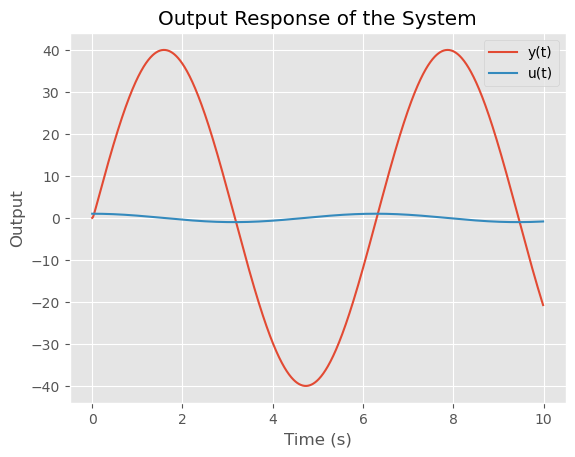

In [310]:
dt =0.01
time = np.arange(0, 10, dt)
f = 1
u_data = np.cos(f*time)#+np.cos(2*time)+np.cos(3*time)

# Step 3: Simulate the output using forced_response
results = ctrl.forced_response(H_s, T=time, U=u_data)

# Plotting the results
plt.figure()
plt.plot(results.time, results.outputs,label='y(t)')
plt.plot(time,u_data,label='u(t)')
plt.title('Output Response of the System')
plt.xlabel('Time (s)')
plt.ylabel('Output')
plt.legend()

plt.show()

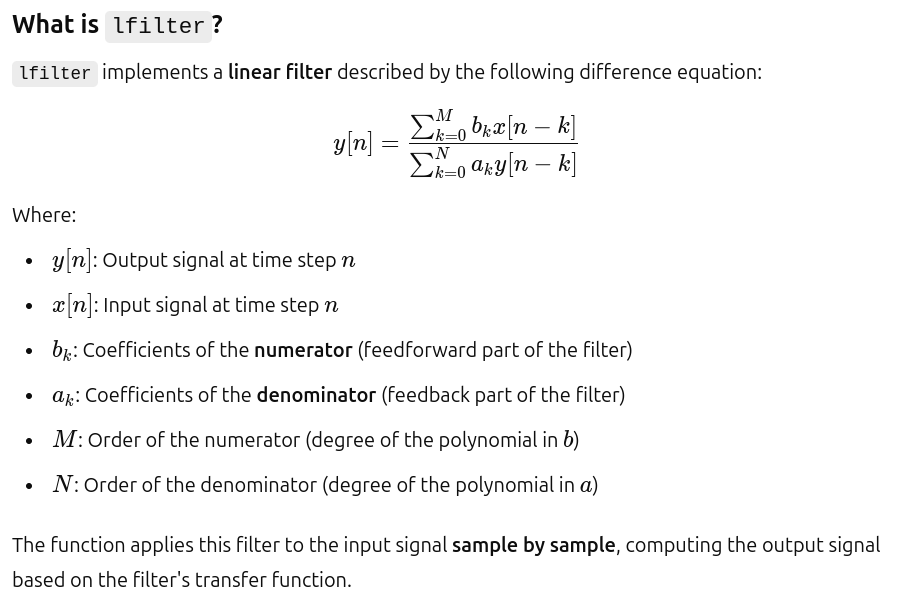

In [311]:
a = np.array([1,2])
b = np.array([3,4])
c = np.array([5,6])

np.hstack((a,b,c))

array([1, 2, 3, 4, 5, 6])

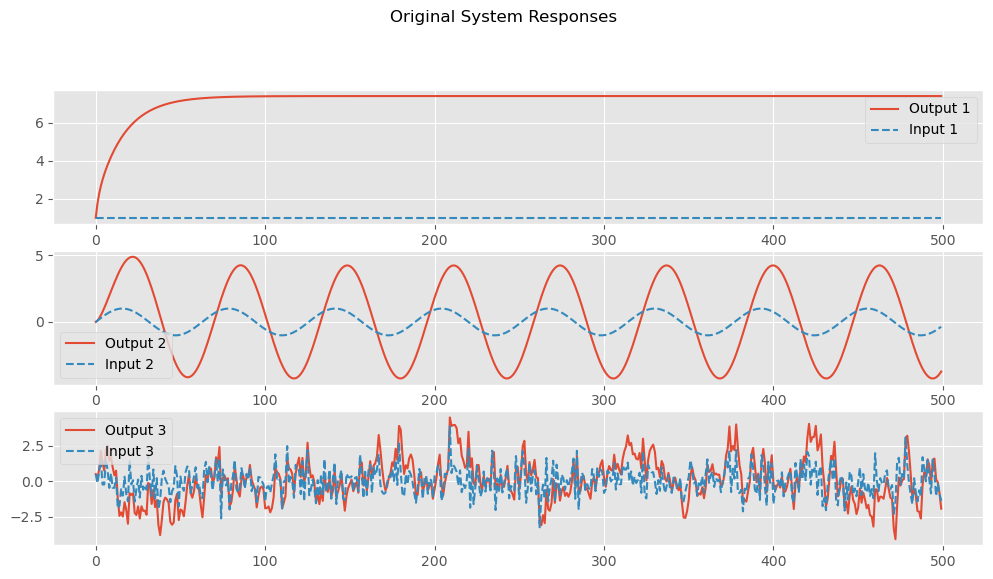

In [312]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter
from scipy.optimize import curve_fit

# Define the original system transfer function
def simulate_system(input_signal):
    # Numerator and denominator coefficients of G(z^-1)
    numerator = [1, -0.8]
    denominator = np.convolve([1, -0.1], np.convolve([1, -0.5], [1, -0.94]))
    # Simulate the system response
    output_signal = lfilter(numerator, denominator, input_signal)
    return output_signal

# Generate input-output data
np.random.seed(42)  # For reproducibility
N = 500  # Number of samples
t = np.arange(N)

# Example input signals: step, sine, and random noise
step_input = np.ones(N)
sine_input = np.sin(0.1 * t)
random_input = np.random.normal(0, 1, N)
input_t = np.hstack((step_input,sine_input,random_input))

# Simulate outputs
step_output = simulate_system(step_input)
sine_output = simulate_system(sine_input)
random_output = simulate_system(random_input)
output_t = simulate_system(input_t)

# Combine input-output pairs
inputs = [step_input, sine_input, random_input]
outputs = [step_output, sine_output, random_output]

# Plot the original system responses
plt.figure(figsize=(12, 8))
for i, (input_signal, output_signal) in enumerate(zip(inputs, outputs)):
    plt.subplot(4, 1, i + 1)
    plt.plot(output_signal, label=f'Output {i+1}')
    plt.plot(input_signal, '--', label=f'Input {i+1}')
    plt.legend()
plt.suptitle("Original System Responses")
plt.show()

# plt.figure(figsize=(15, 6))
# plt.plot(output_t, label=f'Output')
# plt.plot(input_t, '--', label=f'Input')
# plt.legend()
# plt.suptitle("Original System Responses")
# plt.show()

In [313]:
# System identification using least squares
def estimate_output_third_order(input_signal, b1, a1, a2, a3):
    """Model for system identification: y[n] = b1*u[n-1] - a1*y[n-1] - a2*y[n-2] - a3*y[n-3]"""
    y = np.zeros_like(input_signal)
    for n in range(3, len(input_signal)):
        y[n] = (b1 * input_signal[n - 1]
                - a1 * y[n - 1]
                - a2 * y[n - 2]
                - a3 * y[n - 3])
    return y

def estimate_output_second_order(input_signal, b1, a1, a2):
    """Model for a second-order system: y[n] = b1*u[n-1] - a1*y[n-1] - a2*y[n-2]"""
    y = np.zeros_like(input_signal)
    for n in range(2, len(input_signal)):  # Start at n=2 because of y[n-2]
        y[n] = (b1 * input_signal[n - 1]
                - a1 * y[n - 1]
                - a2 * y[n - 2])
    return y

def estimate_output_first_order(input_signal, b1, a1):
    """Model for a first-order system: y[n] = b1*u[n-1] - a1*y[n-1]"""
    y = np.zeros_like(input_signal)
    for n in range(1, len(input_signal)):  # Start at n=1 because of y[n-1]
        y[n] = (b1 * input_signal[n - 1]
                - a1 * y[n - 1])
    return y


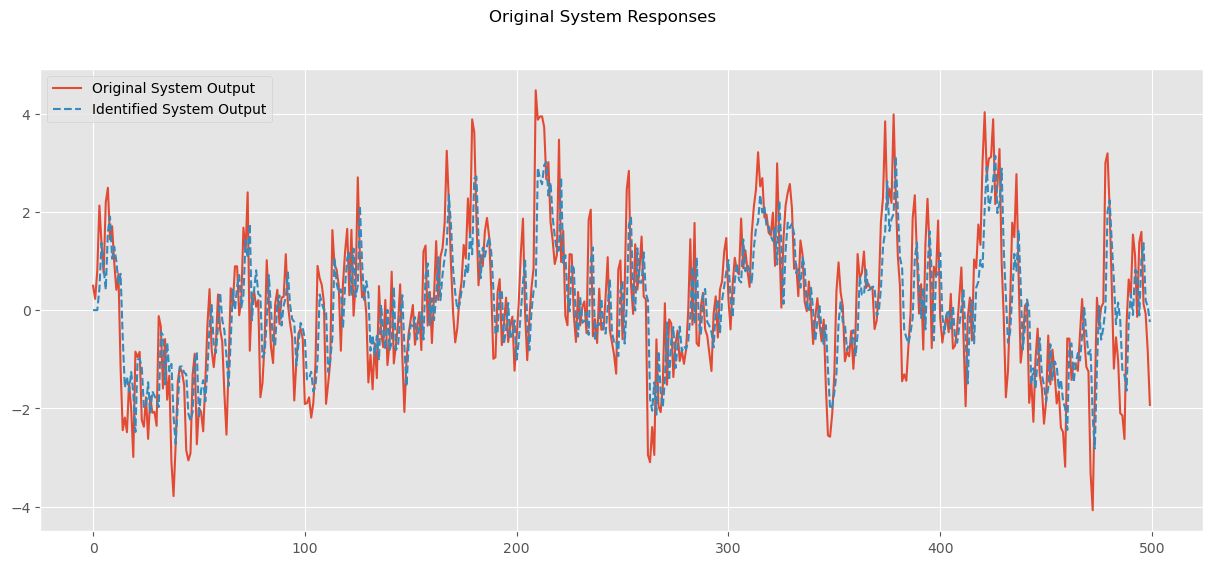

Identified Parameters:
 b1=0.675, a1=-0.782, a2=0.141, a3=-0.235


In [314]:
# Fit model to random input-output data
params, _ = curve_fit(lambda u, b1, a1, a2, a3: estimate_output_third_order(u, b1, a1, a2, a3),
                       random_input, random_output, p0=[1, 1, 1, 1])

# Extract identified parameters
b1, a1, a2, a3 = params

# Simulate the identified system
def identified_system(input_signal):
    return estimate_output_third_order(input_signal, b1, a1, a2, a3)

third_o = identified_system(random_input)
plt.figure(figsize=(15, 6))
plt.plot(random_output, label="Original System Output")
plt.plot(third_o, '--', label="Identified System Output")
plt.legend()
plt.suptitle("Original System Responses")
plt.show()

print(f"Identified Parameters:\n b1={b1:.3f}, a1={a1:.3f}, a2={a2:.3f}, a3={a3:.3f}")

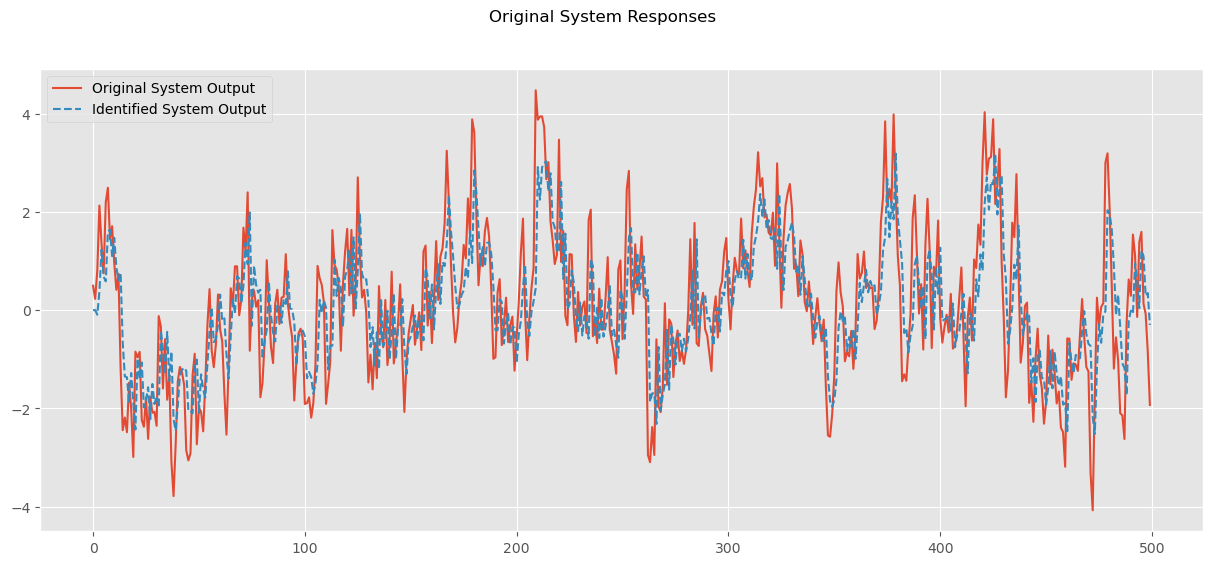

Identified Parameters:
 b1=0.674, a1=-0.598, a2=-0.274


In [315]:
# Fit model to random input-output data
params, _ = curve_fit(lambda u, b1, a1, a2: estimate_output_second_order(u, b1, a1, a2),
                       random_input, random_output, p0=[1, 1, 1])

# Extract identified parameters
b1, a1, a2 = params

# Simulate the identified system
def identified_system(input_signal):
    return estimate_output_second_order(input_signal, b1, a1, a2)

second_o = identified_system(random_input)
plt.figure(figsize=(15, 6))
plt.plot(random_output, label="Original System Output")
plt.plot(second_o, '--', label="Identified System Output")
plt.legend()
plt.suptitle("Original System Responses")
plt.show()

print(f"Identified Parameters:\n b1={b1:.3f}, a1={a1:.3f}, a2={a2:.3f}")

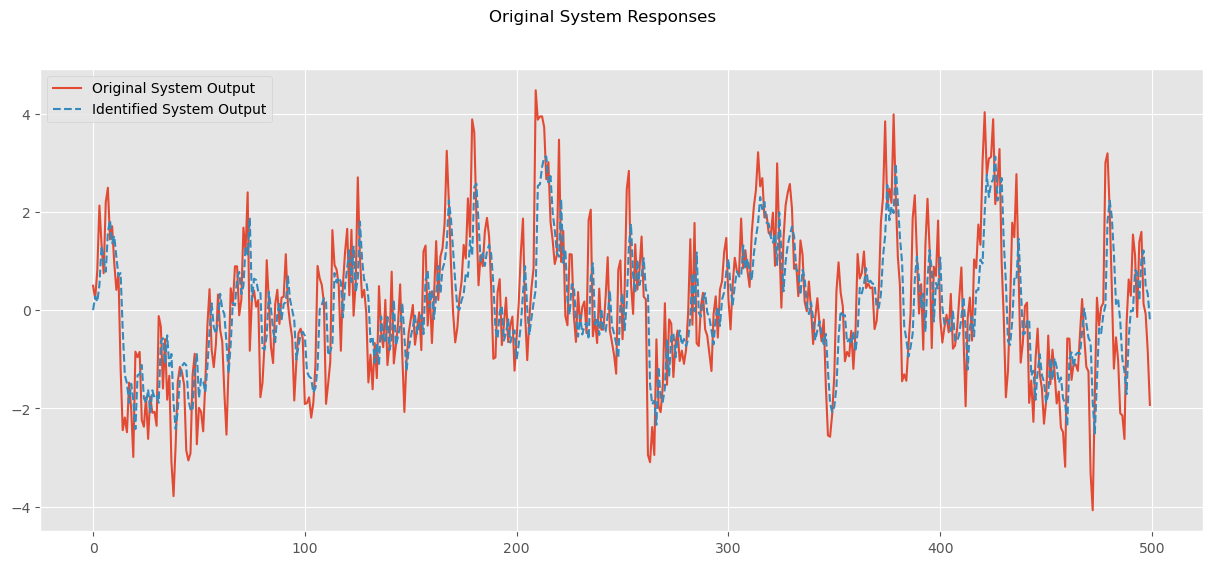

Identified Parameters:
 b1=0.560, a1=-0.887


In [316]:
# Fit model to random input-output data
params, _ = curve_fit(lambda u, b1, a1: estimate_output_first_order(u, b1, a1),
                       random_input, random_output, p0=[1, 1])

# Extract identified parameters
b1, a1 = params

# Simulate the identified system
def identified_system(input_signal):
    return estimate_output_first_order(input_signal, b1, a1)

first_o = identified_system(random_input)
plt.figure(figsize=(15, 6))
plt.plot(random_output, label="Original System Output")
plt.plot(first_o, '--', label="Identified System Output")
plt.legend()
plt.suptitle("Original System Responses")
plt.show()

print(f"Identified Parameters:\n b1={b1:.3f}, a1={a1:.3f}")

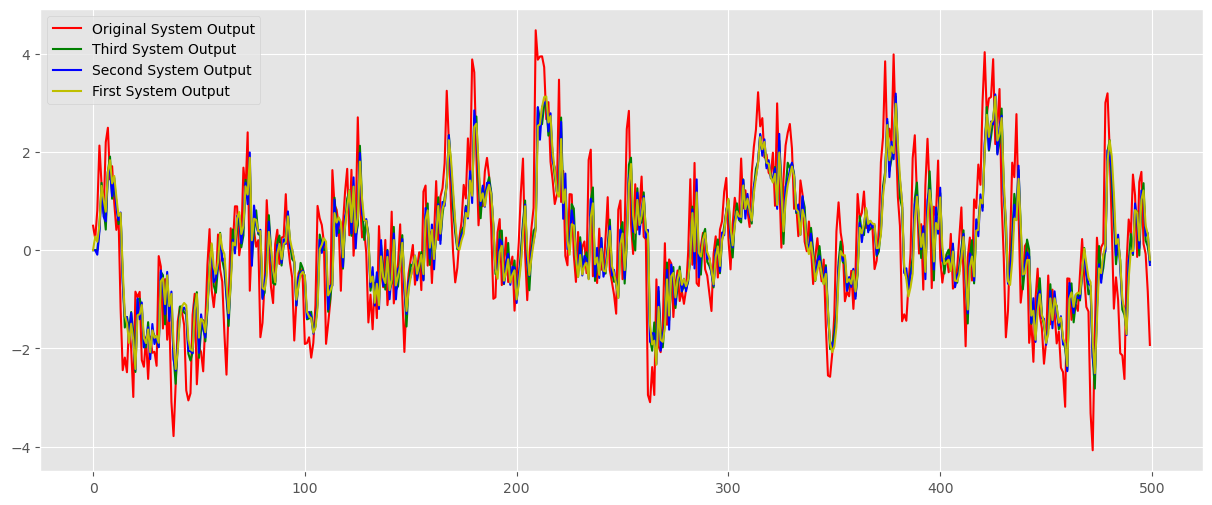

In [317]:
plt.figure(figsize=(15, 6))
plt.plot(random_output, color='r', label="Original System Output")
plt.plot(third_o, color='g', label="Third System Output")
plt.plot(second_o, color='b', label="Second System Output")
plt.plot(first_o, color='y', label="First System Output")
plt.legend()
plt.show()